## * Tensorflow GPU 확인

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.__version__
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7223906648966125011
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10084089856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15994566812651405081
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


## 1. 패키지 로드

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.layers.merge import concatenate
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from matplotlib import font_manager, rc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [3]:
# 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## 2. 데이터 로드

In [4]:
train_df = pd.read_csv("./train.csv")
train_df.head()

,id,img_path,overview,cat1,cat2,cat3
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식


In [5]:
test_df = pd.read_csv("./test.csv")
test_df.head()

,id,img_path,overview
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ..."
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...


- 문제 : image와 overview를 이용하여 cat3를 예측하는 문제

## 3. 데이터 분석

### 1) Data Summary 확인

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16986 entries, 0 to 16985
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        16986 non-null  object
 1   img_path  16986 non-null  object
 2   overview  16986 non-null  object
 3   cat1      16986 non-null  object
 4   cat2      16986 non-null  object
 5   cat3      16986 non-null  object
dtypes: object(6)
memory usage: 796.3+ KB


- 총 16986개의 Data, Null값이 없다.

### 2) 분류 항목 확인

In [7]:
# 1, 분류 항목 종류 확인
train_df['cat3'].unique()

array(['항구/포구', '골프', '한식', '야영장,오토캠핑장', '섬', '일반축제', '유적지/사적지', '일식',
       '자연휴양림', '전시관', '관광단지', '모텔', '스키(보드) 렌탈샵', '바/까페', '채식전문점',
       '한옥스테이', '컨벤션', '성', '중식', '안보관광', '전문상가', '이색거리', '해수욕장', '5일장',
       '미술관/화랑', '공원', '상설시장', '박물관', '도서관', '공연장', '농.산.어촌 체험', '복합 레포츠',
       '펜션', '산', '기념탑/기념비/전망대', '기념관', '자동차경주', '자전거하이킹', '희귀동.식물',
       '유명건물', '수목원', '유원지', '사찰', '강', '자연생태관광지', '박람회', '문화전수시설', '계곡',
       '폭포', '서양식', '종교성지', '동상', '기타행사', '고택', '국립공원', '게스트하우스', '썰매장',
       '요트', '문화원', '래프팅', '승마', '공예,공방', '트래킹', '온천/욕장/스파', '수련시설',
       '해안절경', '패밀리레스토랑', '기암괴석', '기타', '홈스테이', '민물낚시', '콘도미니엄', '민박',
       '테마공원', '유람선/잠수함관광', '바다낚시', '수영', '백화점', '호수', '카약/카누', '외국문화원',
       '면세점', '다리/대교', '카지노', '분수', '동굴', '도립공원', '윈드서핑/제트스키', '특산물판매점',
       '유스호스텔', '고궁', '서비스드레지던스', '민속마을', '전통공연', '문', '식음료', '번지점프',
       '터널', '문화관광축제', '카트', '클럽', '발전소', '대중콘서트', 'MTB', '군립공원', '스케이트',
       '대형서점', '생가', '스카이다이빙', '영화관', '헹글라이딩/패러글라이딩', '스노쿨링/스킨스쿠버다이

In [8]:
# 2. 분류 항목 갯수 확인
print(f"train data cat3의 총 분류 항목은 {len(train_df['cat3'].unique())}개 입니다.")

train data cat3의 총 분류 항목은 128개 입니다.


In [9]:
# 3. 분류 항목별 Count 확인
train_df['cat3'].value_counts()

한식                3438
야영장,오토캠핑장         1558
바/까페               785
유적지/사적지            622
일반축제               549
                  ... 
MTB                  2
대중콘서트                2
인라인(실내 인라인 포함)       2
스카이다이빙               2
클래식음악회               2
Name: cat3, Length: 128, dtype: int64

             cat3  count
0             5일장    165
1             ATV      4
2             MTB      2
3               강    104
4          게스트하우스     83
..            ...    ...
123          헬스투어     15
124  헹글라이딩/패러글라이딩      9
125            호수     30
126          홈스테이     57
127        희귀동.식물     88

[128 rows x 2 columns]


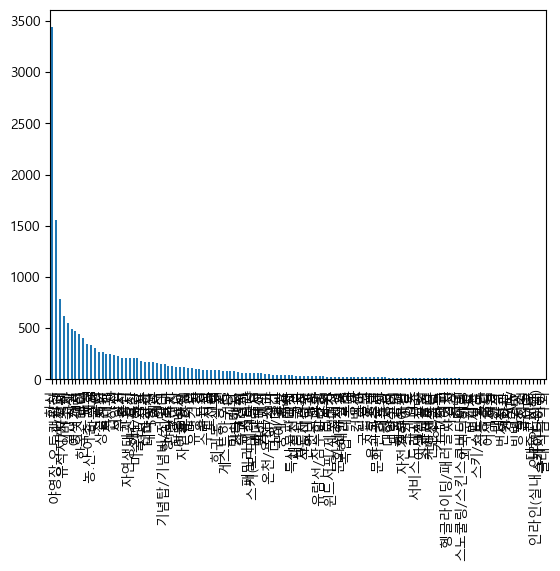

In [10]:
# 4. 불균형 확인을 위한 시각화
train_df['cat3'].value_counts().plot(kind = 'bar')
print(train_df.groupby('cat3').size().reset_index(name = 'count'))

- 항목별 개수가 비대칭이므로 학습 데이터와 테스트 데이터를 나눌 때 유의해야한다.

### 3) Overview 길이 분포 및 최솟값, 최댓값 확인

In [11]:
# 1. overview의 길이로 새로운 columns 생성
train_df['overview_len'] = train_df['overview'].apply(lambda x : len(x))

In [39]:
# 2. overview_len의 최솟값, 최댓값 확인
train_df['overview_len'].min(), train_df['overview_len'].max(), train_df['overview_len'].median()

(7, 7972, 274.0)

In [13]:
# 3. overview_len의 최솟값 확인
train_df[train_df['overview_len'] == 7]['overview'] # 길이가 가장 짧은 overview

3030    홈페이지 참조
Name: overview, dtype: object

In [14]:
# 4. overview_len의 최댓값 확인
train_df[train_df['overview_len'] == 7972]['overview'] # 길이가 가장 긴 overview

1399    우리나라 3대 사찰의 하나로 신라 애장왕 3년(802)에 순응, 이정 두 스님이 창...
Name: overview, dtype: object

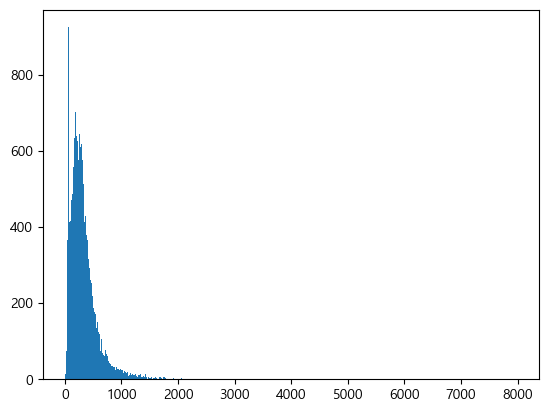

In [15]:
# 5. overview의 길이 분포 확인
plt.hist(train_df['overview_len'], bins=500)
plt.show()

In [16]:
# 6. overview 길이 하위 30개의 실제 값 확인
train_df.sort_values("overview_len")[:30]

,id,img_path,overview,cat1,cat2,cat3,overview_len
3030,TRAIN_03030,./image/train/TRAIN_03030.jpg,홈페이지 참조,인문(문화/예술/역사),공연/행사,기타행사,7
12570,TRAIN_12570,./image/train/TRAIN_12570.jpg,양구에 위치한 민박이다.,숙박,숙박시설,펜션,13
11168,TRAIN_11168,./image/train/TRAIN_11168.jpg,역사의 깊이가 있는 고택이다.,숙박,숙박시설,홈스테이,16
14695,TRAIN_14695,./image/train/TRAIN_14695.jpg,쫄면이 맛있는 분식 전문점이다.,음식,음식점,한식,17
15531,TRAIN_15531,./image/train/TRAIN_15531.jpg,"크리스마스 트리니팅, 빛의 거리 조성",인문(문화/예술/역사),공연/행사,기타행사,20
5390,TRAIN_05390,./image/train/TRAIN_05390.jpg,푸른자연과 함께하는 한적한 가족캠핑장,레포츠,육상 레포츠,"야영장,오토캠핑장",20
13388,TRAIN_13388,./image/train/TRAIN_13388.jpg,안동 시내에 위치한 한정식 전문점이다.,음식,음식점,한식,21
3387,TRAIN_03387,./image/train/TRAIN_03387.jpg,산모랭이펜션은 진부면에 위치하고 있다.,숙박,숙박시설,펜션,21
10378,TRAIN_10378,./image/train/TRAIN_10378.jpg,파주시와 함께하는 2021경기건축문화제,인문(문화/예술/역사),축제,일반축제,21
14507,TRAIN_14507,./image/train/TRAIN_14507.jpg,다양한 쟝르 청년 예술인들의 공연 축제,인문(문화/예술/역사),축제,일반축제,21


- 길이가 가장 짧은 overview를 제외하고는 의미있는 Text가 담겨있는 것을 확인할 수 있다.
- 따라서 모델 성능 향상을 위해 해당 overview를 제거하거나, image를 보고 overview를 재작성하는 것을 고려할 수 있다.

## 4. 데이터 전처리

### 1) 텍스트 전처리
- Multi-Modal이기 때문에 image와 text가 모두 중복이 아니면 그대로 둔다.
    - ex) 같은 관광명소의 사진을 다른 구도로 촬영하고 설명은 같을 수 있기 때문.
    - 위와같은 경우 데이터를 제외하면 관광지를 특정할 수 있는 요소가 하나 사라지므로 성능이 악화될 것

#### (1) 이상치 overview 채우기

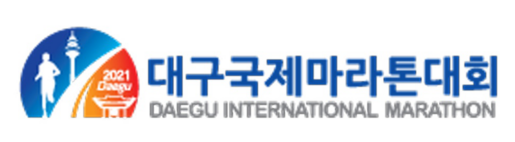

In [17]:
# 1. 이상치에 해당하는 overview의 이미지
outlier_overview_image = cv2.imread(train_df.iloc[3030]['img_path'])
plt.imshow(cv2.cvtColor(outlier_overview_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [18]:
# 2. 대구국제마라톤을 검색해보고 overview를 채워넣기
train_df.loc[3030, 'overview'] = "대구국제마라톤대회는 대한민국의 대구에서 매년 4월에 열리는 마라톤 대회이다. 세계육상연맹이 10년 연속 '실버라벨'을 인정한 국제마라톤 대회이다."
train_df.iloc[3030]

id                                                    TRAIN_03030
img_path                            ./image/train/TRAIN_03030.jpg
overview        대구국제마라톤대회는 대한민국의 대구에서 매년 4월에 열리는 마라톤 대회이다. 세계육...
cat1                                                 인문(문화/예술/역사)
cat2                                                        공연/행사
cat3                                                         기타행사
overview_len                                                    7
Name: 3030, dtype: object

#### (2) 한글외의 문자 제거

In [20]:
train_df['overview'] = train_df['overview'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_df['overview'].replace('', np.nan, inplace=True)
train_df.isnull().sum() # 전처리 과정에서 null값이 생기는지 확인

C:\Users\Park Ji Seong\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id              0
img_path        0
overview        0
cat1            0
cat2            0
cat3            0
overview_len    0
dtype: int64

In [21]:
train_df['overview'].head()

0    소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...
1    경기도 이천시 모가면에 있는 골프장으로 대중제 홀이다 회원제로 개장을 했다가 년 대...
2    금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...
3    철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다 경상북도 안동시에 있는 한식 ...
4       영업시간   대에 걸쳐 아귀만을 전문으로 취급하는 전통과 역사를 자랑하는 음식점이다
Name: overview, dtype: object

#### (3) 형태소 토큰화

In [19]:
# 1. Mecab 형태소 분석기 로드
mecab = Mecab('C:\mecab\mecab-ko-dic')

In [22]:
# 2. 형태소 토큰화
train_df['tokenized'] = train_df['overview'].apply(mecab.morphs)
train_df['tokenized'].head()

0    [소안항, 은, 조용, 한, 섬, 으로, 인근, 해안, 이, 청정, 해역, 으로, ...
1    [경기도, 이천시, 모가면, 에, 있, 는, 골프장, 으로, 대중, 제, 홀, 이,...
2    [금오, 산, 성, 숯불갈비, 는, 한우, 고기, 만, 을, 전문, 적, 으로, 취...
3    [철판, 위, 에서, 요리, 하, 는, 안동, 찜, 닭, 을, 맛볼, 수, 있, 는...
4    [영업시간, 대, 에, 걸쳐, 아귀, 만, 을, 전문, 으로, 취급, 하, 는, 전...
Name: tokenized, dtype: object

#### (4) 정수 인코딩

In [24]:
# 1. X 정의
train_txt_X = train_df['tokenized'].values

In [25]:
# 2. Tokenizer 학습
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_txt_X)

In [30]:
# 3. Word index 확인
# tokenizer.word_index

In [33]:
# 4. 희귀 단어 제거 여부 결정
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 54693
등장 빈도가 1번 이하인 희귀 단어의 수: 19548
단어 집합에서 희귀 단어의 비율: 35.74131973013
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8006625494884656


- 대부분 텍스트에서 희귀단어가 존재하므로 제거하지 않는다.

In [34]:
# 5. vocab size 설정
vocab_size = total_cnt + 2 # OOV 토큰과 0번 패딩 토큰을 고려하여 + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 54695


In [35]:
# 6. 최종 토크나이저 학습 및 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(train_txt_X)
train_txt_X = tokenizer.texts_to_sequences(train_txt_X)

In [37]:
# 7. 토큰 값 확인
print(train_txt_X[:3])

[[35147, 10, 668, 12, 201, 14, 141, 402, 2, 481, 2467, 14, 5053, 1030, 470, 7, 383, 224, 10, 3558, 7, 1639, 11, 5, 33, 2629, 7143, 21, 132, 9, 4, 1936, 94, 6, 179, 41, 4519, 23, 10, 27232, 23, 8, 15897, 12, 3797, 7, 35148, 522, 9142, 340, 11, 5, 33, 1329, 92, 201, 8, 6926, 10, 119, 8, 796, 7, 366, 862, 11, 5, 3, 277, 9, 4, 91, 201, 6, 3, 283, 17588, 673, 12504, 209, 24, 8, 2724, 15, 750, 1354, 11, 5, 33, 457, 4017, 12505, 4856, 2, 683, 11, 5, 4], [227, 5946, 13384, 6, 5, 3, 706, 14, 1186, 211, 509, 2, 4, 1890, 211, 17, 832, 7, 85, 260, 26, 1186, 211, 17, 5514, 9, 27, 405, 832, 85, 4, 272, 845, 134, 6, 6431, 6, 509, 400, 2, 4, 124, 25, 124, 15, 5, 4, 1680, 74, 1026, 124, 15898, 28, 3034, 35149, 15, 14525, 97, 3, 500, 11, 2500, 3741, 97, 3, 2301, 30, 1077, 85, 149, 39, 681, 6, 19768, 22775, 2401, 4177, 4446, 1560, 22776, 13385, 12506, 24, 8, 706, 2, 5, 4], [4178, 62, 103, 6580, 3, 373, 382, 46, 7, 261, 35, 14, 1561, 9, 11, 120, 9, 3, 13386, 5947, 91, 5054, 5663, 14, 685, 12, 481, 1013, 4

#### (5) 패딩

In [40]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [45]:
max_len = 600
below_threshold_len(max_len, train_txt_X)

전체 샘플 중 길이가 600 이하인 샘플의 비율: 99.04038620040033


- 600의 길이로 패딩할 경우 99% 이상의 샘플이 보전됨으로 600으로 패딩한다.

In [46]:
train_txt_X = pad_sequences(train_txt_X, maxlen=max_len)